## Face-Recognition

##### References --> 
##### 1.) https://www.geeksforgeeks.org/ml-face-recognition-using-eigenfaces-pca-algorithm/
##### 2.) https://www.youtube.com/watch?v=5HNr_j6LmPc

##### How i trained my own Cascade Classifier using OpenCV? (Given in the README.md) --> https://github.com/Lovepreet-Singh-LPSK/Face-Recognition 

In [1]:
# Importing necessary libraries
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import random
import scipy

## TRAINING :-
#### 1.) Use Viola Jones to detect Faces from images.
#### 2.) Crop Images to Faces Only.
#### 3.) Stack images into an array with images labels in another array. Images then divided into Train and Test.
#### 4.) Calculate Mean Face of training face and substract from each Face.
#### 5.) Calculate Covariance Matrix from that Resulted Matrix.
#### 6.) Calculate eigenvectors and eigenvalues wrt that Covariance Matrix.
#### 7.) Pick top eigenvectors by referring to the top eigenvalues and express each face to the linear combination of the eigenfaces.
#### 8.) Store the weights of the linear combination in array to use later for distance calculation.

In [2]:
# Note:
#     No. of Total Images = 166
#     No. of Training Images = 133
#     No. of Testing Images = 33
#     Dimensions of images = 40*40

In [3]:
#Using Pretrained Cascade classifier for better performance.
face_cascade = cv2.CascadeClassifier(cv2.haarcascades + "haarcascade_frontalface_default.xml")

images = [] #Images to be stored

ndim = (40,40) #Consistent dimension of the images used in all the code

df_faces = pd.read_csv("yalefaces/yalefaces.csv", names = ["Label","x","y","w","h","Path","W","H"])

images_paths = df_faces["Path"].values #Images paths

Labels = df_faces['Label'].values #Images labels for face-rec.

for image_path in (images_paths): 

    img = cv2.imread("yalefaces2/" + image_path, cv2.IMREAD_GRAYSCALE) #Reading image in gray scale
    
    faces = face_cascade.detectMultiScale(img, 1.3, 5) 
    
    if faces != () : #If face is detected using Haarcascade classifier
    
        x,y,w,h = faces[0][0], faces[0][1], faces[0][2], faces[0][3] #Coordinates of the face detected rectangle
    
        img = img[y:y+h, x:x+w] #Face crop for use in eigenFace algo.
    
        img = cv2.resize(img, ndim) #Maintaing consitency in image size
    
        img = np.asarray(img,dtype=float)/255.0 #Normilizing the image pixels
    
        images.append(img.flatten()) #Flat image
        
    
    else: #If face is not detected store entire image instead of face
    
        img = cv2.resize(img, ndim)
    
        img = np.asarray(img,dtype=float)/255.0
    
        images.append(img.flatten())

In [4]:
def shuffle_split(X, Y): #Randomly shuffling and splitting the data into Train and Test sets
    no_for_test, no_for_train = [], []
    count = 0
    while count != 33: #33 Images for testing
        x = random.randint(0,165)
        if (x in no_for_test) or (x in no_for_train):
            continue
        else:
            no_for_test.append(x)
            count+=1
    count = 0
    while count!=133: #133 Images for training
        x = random.randint(0,165)
        if (x in no_for_train) or (x in no_for_test):
            continue
        else:
            no_for_train.append(x)
            count+=1
    return X[no_for_train,], Y[no_for_train], X[no_for_test,], Y[no_for_test]

images = np.matrix(images) #Change to np array

X, Y = images, Labels

X_train, Y_train, X_test, Y_test = shuffle_split(X,Y) #Data shuffling and dividing into train and test

flattened_images = X_train # Flattened images in an array. Shape -- Mx(N*N)
image = flattened_images

print("Complete Dataset Shapes: X_train.shape , Y_train.shape , X_test.shape, Y_test.shape -- ",X_train.shape , Y_train.shape , X_test.shape, Y_test.shape)

Complete Dataset Shapes: X_train.shape , Y_train.shape , X_test.shape, Y_test.shape --  (133, 1600) (133,) (33, 1600) (33,)


In [5]:
def ImagesDisplay(images): #Function to display images in 5x5 grid
    fig1, axes = plt.subplots(5, 5)
    fig1.set_size_inches(5, 5)
    k=0
    for row in range(5):
        for col in range(5):    
            im = np.reshape(images[k],(40,40))
            image_plot = axes[row][col].imshow(im,cmap = plt.cm.gray) 
            axes[row][col].axis('off')
            k = k+1
    plt.show()

avg = np.mean(flattened_images.T, 1) # Average matrix 
print("Shape of the mean_image : (%d,%d)"%avg.shape)

Shape of the mean_image : (1600,1)


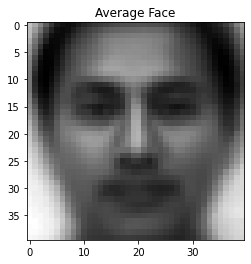

In [6]:
#Mean Face
temp_image = avg.reshape(40,40)
plt.imshow(temp_image, cmap = "gray")
plt.title("Average Face")
plt.show()

In [7]:
Difference_mat = [] # Creating a difference matrix 
for i in range(len(image)):
    diff = flattened_images[i].T - avg
    Difference_mat.append(diff.tolist())
Difference_mat = np.array(Difference_mat) #Shape -- [Mx(N*N)]
Difference_mat = np.squeeze(Difference_mat, axis = 2).T
print("Shape of Difference Matrix: ",Difference_mat.shape)

Shape of Difference Matrix:  (1600, 133)


In [8]:
Cov_1 = np.dot(np.transpose(Difference_mat), (Difference_mat)) # Shape of the matrix MxM
print("Con_1 Matrix Shape: ",Cov_1.shape)

w,v = np.linalg.eig(Cov_1) #Eigenvector and eigenvalues of Cov_1
ind = w.argsort()[::-1]
w_sort = w[ind]
v_sort = v[ind] #Sorted eigenvectors
# print(v_sort.shape)
u = np.dot((Difference_mat),v_sort) # Eigen Vector of Covarince Matrix
u = np.transpose(u) 
u_norm = np.zeros((len(flattened_images),1600))

Con_1 Matrix Shape:  (133, 133)


Eigen Faces -->


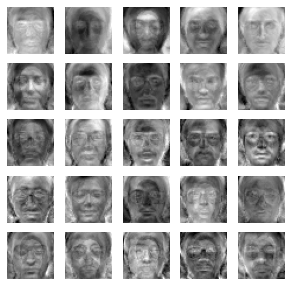

In [9]:
u_list = []
for i in range(len(flattened_images)): #Normalized u
    u_norm[i] = u[i]/np.linalg.norm(u[i], ord=2, axis=0, keepdims=True)
    u_list.append(u_norm[i].reshape(40,40))
weight_mat = [] #Weight Matrix
print("Eigen Faces -->")
ImagesDisplay(u_list)

		k=2


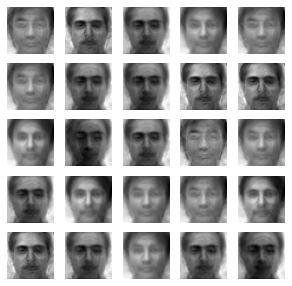

		k=5


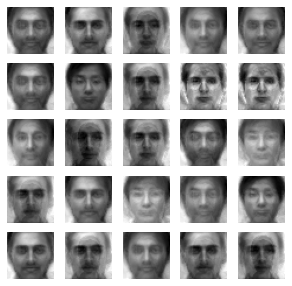

		k=15


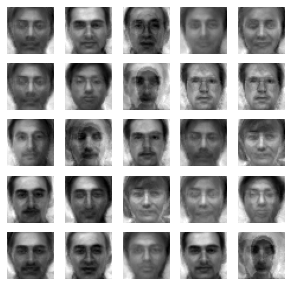

In [10]:
dict = {}
def FaceRec(k):
    weights = np.zeros((133,k))
    const_u = np.zeros((1600,k))
    c = 0
    for value in range(0,k):
        const_u[:,c] = u_list[value].flatten()
        c = c+1
    rec_face=[]
    for face_num in range(0,133): # Finding Weights of faces
        w = np.dot(np.transpose(const_u) ,Difference_mat[:,face_num])
#         print(w.shape)
        #w = Zero_mean_matrix[:,face_num]*np.transpose(matrixU)  
        weights[face_num,:] = w
        #face=np.zeros((1, 180625))
        #         face = np.dot(w[0], matrixU[:,0])
        #         for i in range(1,k):
        #             face = face + np.dot(w[i], matrixU[:,i])
        #         #print(face.shape)
        #         face = face+np.transpose(mean)

        face = np.dot(w, np.transpose(const_u))
        # Applying Centeral Theorm on the Face Recognized
        minf = np.min(face)
        maxf = np.max(face)
        face = face-float(minf)
        face = face/float((maxf-minf))
        face = face+np.transpose(avg)
        reshape_face = face.reshape(40,40)
        rec_face.append(reshape_face)
    
    ImagesDisplay(rec_face)
    dict[k] = weights

print('\t\tk=2')
FaceRec(2)
print('\t\tk=5')
FaceRec(5)
print('\t\tk=15')
FaceRec(15)

-------------------K = 2-------------------



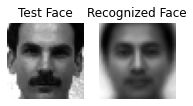

subject10
-------------


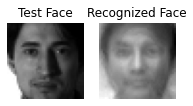

subject14
-------------


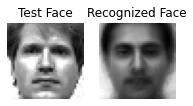

subject9
-------------


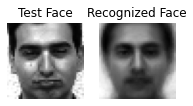

subject8
-------------


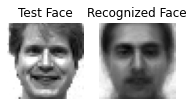

subject9
-------------


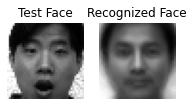

subject13
-------------


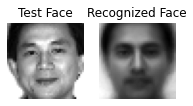

subject3
-------------


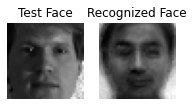

subject14
-------------


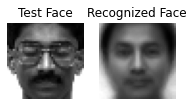

subject7
-------------


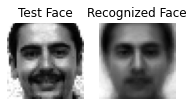

subject8
-------------


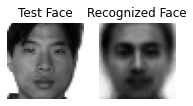

subject4
-------------


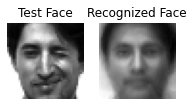

subject5
-------------


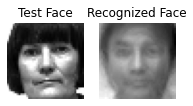

subject11
-------------


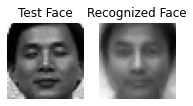

subject6
-------------


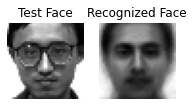

subject8
-------------


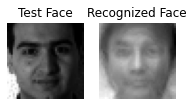

subject11
-------------


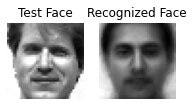

subject9
-------------


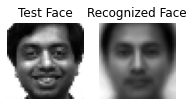

subject10
-------------


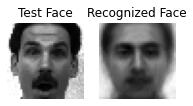

subject5
-------------


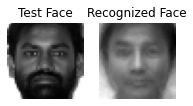

subject6
-------------


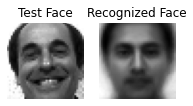

subject12
-------------


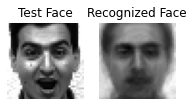

subject15
-------------


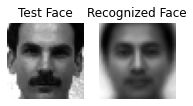

subject10
-------------


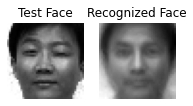

subject14
-------------


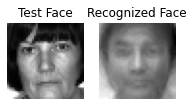

subject11
-------------


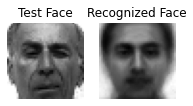

subject10
-------------


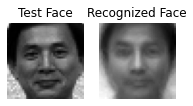

subject6
-------------


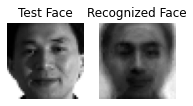

subject9
-------------


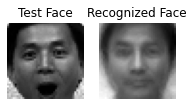

subject6
-------------


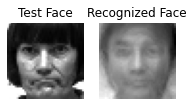

subject13
-------------


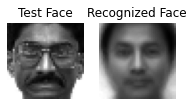

subject13
-------------


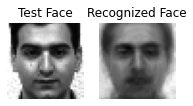

subject9
-------------


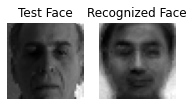

subject14
-------------
-------------------K = 5-------------------



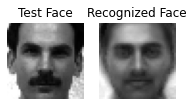

subject2
-------------


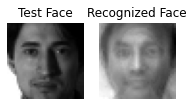

subject14
-------------


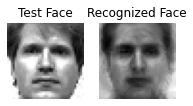

subject1
-------------


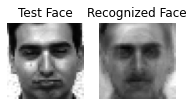

subject15
-------------


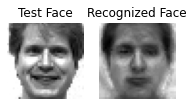

subject1
-------------


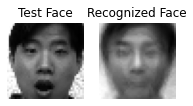

subject4
-------------


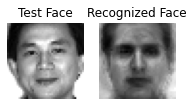

subject1
-------------


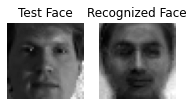

subject14
-------------


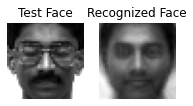

subject13
-------------


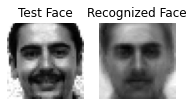

subject8
-------------


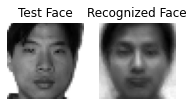

subject14
-------------


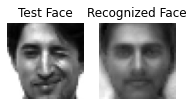

subject3
-------------


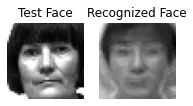

subject11
-------------


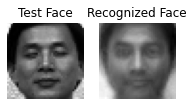

subject6
-------------


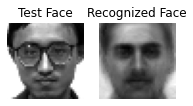

subject8
-------------


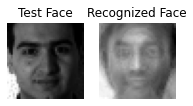

subject13
-------------


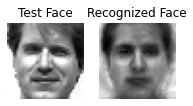

subject1
-------------


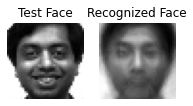

subject10
-------------


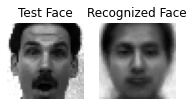

subject8
-------------


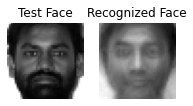

subject6
-------------


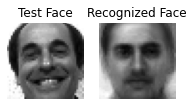

subject9
-------------


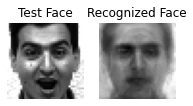

subject15
-------------


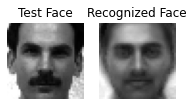

subject2
-------------


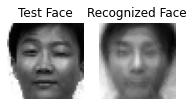

subject14
-------------


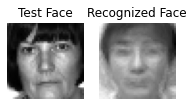

subject11
-------------


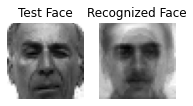

subject5
-------------


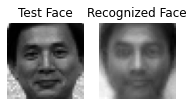

subject6
-------------


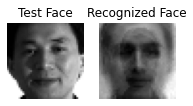

subject9
-------------


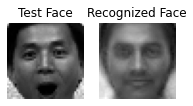

subject6
-------------


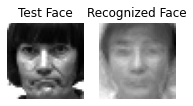

subject11
-------------


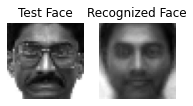

subject13
-------------


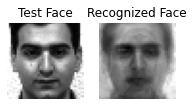

subject15
-------------


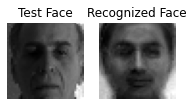

subject14
-------------
-------------------K = 15-------------------



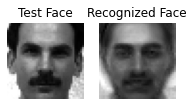

subject2
-------------


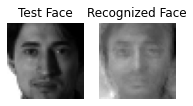

subject14
-------------


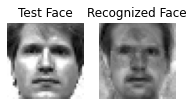

subject1
-------------


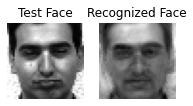

subject15
-------------


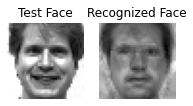

subject1
-------------


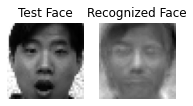

subject4
-------------


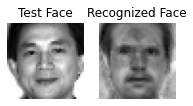

subject1
-------------


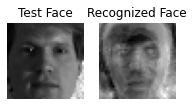

subject14
-------------


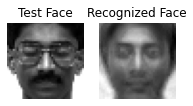

subject13
-------------


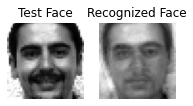

subject9
-------------


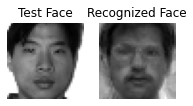

subject14
-------------


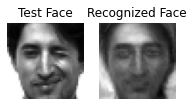

subject3
-------------


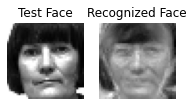

subject11
-------------


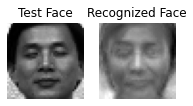

subject6
-------------


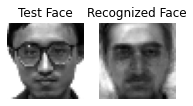

subject8
-------------


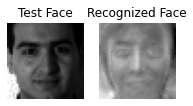

subject13
-------------


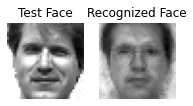

subject1
-------------


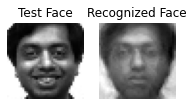

subject10
-------------


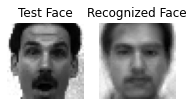

subject8
-------------


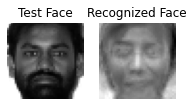

subject6
-------------


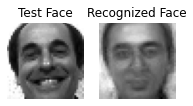

subject12
-------------


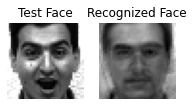

subject15
-------------


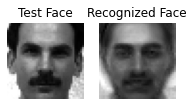

subject2
-------------


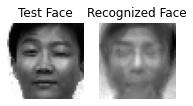

subject14
-------------


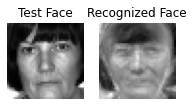

subject11
-------------


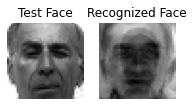

subject5
-------------


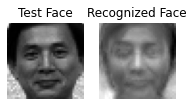

subject6
-------------


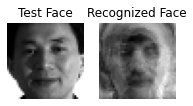

subject9
-------------


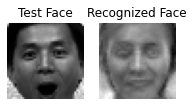

subject6
-------------


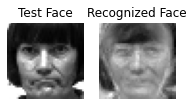

subject11
-------------


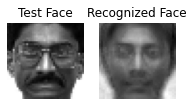

subject13
-------------


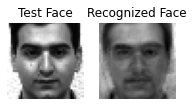

subject15
-------------


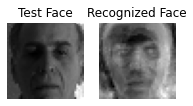

subject14
-------------


In [12]:
test_images = X_test
def Project(k,diff_mat_test,threshold):
    test_u = np.zeros((1600,k))
    c = 0
    for value in range(0,k):
        test_u[:,c] = u_list[value].flatten()
        c = c+1
    w = np.dot(np.transpose(test_u) ,np.transpose(diff_mat_test))
    original_w_k = dict[k]
    dist =[]
    for wt_vectors in original_w_k:
        dist.append(np.linalg.norm(wt_vectors - w.T))

    nearest_face = np.argmin(dist)
    nearest_face_weights = original_w_k[nearest_face]
    fig1, axes_array = plt.subplots(1, 2)
    fig1.set_size_inches(3,3)
    diff_mat_test = diff_mat_test + np.transpose(avg)
    diff_mat_test = diff_mat_test.reshape(40,40)
    image_plot = axes_array[0].imshow(diff_mat_test,cmap=plt.cm.gray)
    axes_array[0].axis('off')
    axes_array[0].set(title='Test Face')

    face = np.dot(nearest_face_weights, np.transpose(test_u))
    face = face + np.transpose(avg)
    reshape_face = face.reshape(40,40)
    if np.min(dist)<threshold:
        image_plot = axes_array[1].imshow(reshape_face,cmap=plt.cm.gray)
    axes_array[1].axis('off')
    axes_array[1].set(title ='Recognized Face')
    plt.show()
    return Y_train[nearest_face]
    

def runs(k):
    accuracy = 0
    for num in range(0,len(test_images)):#t in test_images:
        t = test_images[num]
        test = t.flatten()
        diff_mat_test = test-np.transpose(avg)
        name = Project(k,diff_mat_test,80)  #threshold =80
        print(name)
        print("-------------")
        if name == Y_test[num]:
            accuracy+=1
    return accuracy
print('-------------------K = 2-------------------')
print()
accuracy1 = runs(2)
print('-------------------K = 5-------------------')
print()
accuracy2 = runs(5)
print('-------------------K = 15-------------------')
print()
accuracy3 = runs(15)

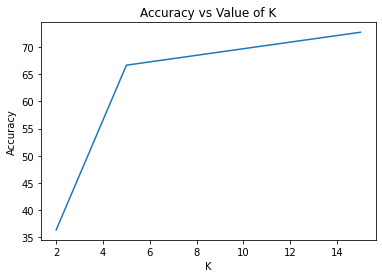

In [13]:
k = [2, 5 , 15]
num_images = len(Y_test)
accuracy = [(accuracy1/num_images)*100, (accuracy2/num_images)*100, (accuracy3/num_images)*100]
plt.plot(k, accuracy, '-')
plt.title("Accuracy vs Value of K")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.show()